In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import os

torch.manual_seed(10)
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

device = 'cpu'

In [4]:
# A common headache in this competition is the lack of determinism in the results due to cudnn, the following solves the issue
def seed_everything(seed=10):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# Here i have to get the ELMO vector in a form, in a format of numpy array.
with open('document_vector.pickle', 'rb') as file:
    vectors = pickle.load(file)
    file.close()

vectors = np.delete(vectors, 1, 1)
vectors = np.delete(vectors, 0, 1)

vectors = torch.from_numpy(np.array(vectors, dtype=np.float64)).view(521, 1, -1).float()
vectors.size()

In [6]:
vectors = np.array([])
labels = np.array([])

In [ ]:
# Reading the features NOTE: Do not run this it is already saved under vectors.pickle
i = 0
vectors = np.array([])
labels = np.array([])
for file in os.scandir('../../feature_extraction/features/'):
    if file.name.endswith('csv'):
        try:
            vector = pd.read_csv(file)
            if (vector.shape[1] == 1044 or vector.shape[1] == 1047):
                # Some files have issues
                continue
            elif (vector.shape[1] == 1046):
                # Some files have an unnecessary column
                vector.drop([vector.columns[0]], axis=1, inplace=True)
            if i == 0:
                vectors = vector.to_numpy()
            else: 
                vectors = np.concatenate((vectors, vector.to_numpy()))
            i+=1
            print(i, end="\r")
        except:
            continue

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
with open("./vectors.pickle", "wb") as f:
    pickle.dump(vectors, f)

In [43]:
with open("./model_inputs/batch1.pickle", 'rb') as f:
    vectors = pickle.load(f)

t = np.array(vectors)
print(t.shape)

rm_indexes = np.isnan(t[:, -1].astype(np.float))

vectors = np.delete(t, rm_indexes, 0)

print(vectors[1])
print(vectors.shape)


labels_list = vectors[:, [2, -1]]
vectors = vectors[:, 3:-1]

labels = labels_list[:, -1].astype(np.float)

print(labels_list.shape)
print(labels.shape)

(30361, 1045)
[1 1 'Chrysinas,' ... 0.0602333582937717 0.1984460353851318 1.0]
(23976, 1045)
(23976, 2)
(23976,)


In [44]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{1.0: 993,
 2.0: 1210,
 3.0: 255,
 4.0: 32,
 5.0: 297,
 6.0: 77,
 7.0: 10695,
 8.0: 9,
 9.0: 11,
 10.0: 10397}

In [45]:
print(vectors.shape)
print(labels.shape)

(23976, 1041)
(23976,)


In [46]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(vectors, labels, test_size=0.2, random_state=42,stratify=labels)

In [47]:
x_train.shape

(19180, 1041)

In [48]:
x_test.shape

(4796, 1041)

In [49]:
y_train.shape

(19180,)

In [104]:
labels = torch.from_numpy(np.array(y_train, dtype=np.int64)).to(device)
labels = labels -1
print(labels.size())
v = torch.from_numpy(np.array(x_train, dtype=np.float64)).view(-1, 1, 1041).float().to(device)
print(v.size())

v2 = torch.from_numpy(np.array(x_test, dtype=np.float64)).view(-1, 1, 1041).float().to(device)
l2 = torch.from_numpy(np.array(y_test, dtype=np.int64)).to(device)
l2 = l2 -1
print(v2.size())
print(l2.size())

torch.Size([19180])
torch.Size([19180, 1, 1041])
torch.Size([4796, 1, 1041])
torch.Size([4796])


In [105]:
# Normalize the vectors
train_mean = v.mean(dim=0, keepdim=True)
train_std = v.std(dim=0, keepdim=True)
normalized_v = (v - train_mean)/train_std

test_mean = v2.mean(dim=0, keepdim=True)
test_std = v2.std(dim=0, keepdim=True)
normalized_v2 = (v2 - test_mean)/test_std

In [107]:
print(normalized_v.size())
print(normalized_v2.size())

torch.Size([19180, 1, 1041])
torch.Size([4796, 1, 1041])


In [108]:
v.size()

torch.Size([19180, 1, 1041])

In [109]:
normalized_v[torch.isnan(normalized_v)] = 0
print(normalized_v.size())
normalized_v2[torch.isnan(normalized_v2)] = 0
print(normalized_v2.size())

torch.Size([19180, 1, 1041])
torch.Size([4796, 1, 1041])


In [110]:
print(train_mean)
print(train_std)

tensor([[[ 0.0535,  0.2796,  0.0000,  ..., -0.0324,  0.1566, -0.1341]]])
tensor([[[0.1270, 0.4488, 0.0000,  ..., 0.2853, 0.3057, 0.3370]]])


In [115]:
class MyDataset(Dataset):
    def __init__(self,dataset):
        self.dataset = dataset
    def __getitem__(self,index):
        data,target = self.dataset[index]
        return data,target,index
    def __len__(self):
        return len(self.dataset)

In [128]:
train = MyDataset(torch.utils.data.TensorDataset(normalized_v, labels))
train_loader = torch.utils.data.DataLoader(train, batch_size = 128, shuffle=True)
print(train_loader)

validation = MyDataset(torch.utils.data.TensorDataset(normalized_v2, l2))
validation_loader = torch.utils.data.DataLoader(validation, batch_size = 128, shuffle=True)
print(train_loader)
for x, y, i in validation_loader:
    print(x)
    print(y)
    print(i)
    break

tensor([[[-0.4326, -0.6365,  0.0000,  ...,  1.5858, -2.4075,  0.6017]],

        [[-0.4326, -0.6365,  0.0000,  ...,  1.4890, -1.6941,  0.3707]],

        [[-0.4326, -0.6365,  0.0000,  ..., -0.0131, -0.6066,  1.7695]],

        ...,

        [[ 0.4697,  1.5708,  0.0000,  ...,  0.0290,  0.2364,  0.7139]],

        [[-0.4326, -0.6365,  0.0000,  ..., -0.2750, -0.6404,  2.0389]],

        [[ 0.9209,  1.5708,  0.0000,  ...,  0.3798,  0.0090, -0.1510]]])
tensor([6, 9, 9, 9, 6, 6, 9, 9, 9, 9, 9, 9, 6, 6, 6, 0, 6, 6, 9, 9, 1, 0, 6, 9,
        6, 6, 6, 6, 9, 6, 9, 6, 6, 6, 6, 1, 9, 9, 9, 6, 0, 9, 9, 6, 6, 9, 6, 9,
        9, 0, 6, 9, 6, 9, 9, 6, 9, 9, 6, 6, 1, 9, 9, 6, 1, 9, 6, 6, 2, 6, 6, 9,
        6, 6, 0, 6, 9, 0, 9, 6, 9, 9, 9, 1, 9, 9, 9, 6, 6, 9, 6, 9, 6, 9, 9, 6,
        9, 6, 5, 6, 9, 9, 6, 6, 6, 6, 9, 9, 9, 9, 1, 1, 9, 9, 9, 6, 9, 1, 9, 6,
        6, 6, 6, 9, 6, 0, 6, 1])
tensor([ 800,  893, 4777, 3938, 4725, 4427, 3449, 1856, 4178, 1724,   50,   57,
        4606, 1128, 2136, 1101, 327

In [75]:
class BiLSTM(nn.Module): 
    # This NLP part Will consist of two bidirectional lstm layers and it's output is 
    # determined by the LSTM's last hidden states or output vectors.

    # This will take as an input a sequence of words and output the last hidden layer
    # the last hidden states of 2-layer bidirectional LSTM will be the input of the last multimodel network 

    def __init__(self, input_size, hidden_dim = 256, layer_dim =2, output_dim = 10):
        super(BiLSTM, self).__init__()
        
        
        #self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = 'cpu'
        self.input_size = input_size
        
        #Hidden dimensions
        self.hidden_dim = hidden_dim # maybe set this to 256

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building the LSTM 
        # batch_first = True causes the input/output to be of shape 3D (batch_dim, seq_dim, feature_dim) 
        # output will be the same dim as the hidden dim
        self.lstm1 = nn.LSTM(input_size, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        
        self.dropout = nn.Dropout2d(p=0.2)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        

    def forward(self, x):
        
        # Initialize hidden state with zeros
        # self.layer_dim * 2. because we have one going forwards and another going backwards
        h0 = torch.randn(self.layer_dim * 2, x.size(0), self.hidden_dim, device=self.device)
        
        
        
        # Initialize cell state
        c0 =  torch.randn(self.layer_dim * 2, x.size(0), self.hidden_dim, device=self.device)
        
        # We suppose we are conducting a 28 time steps In case of using 
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm1(x, (h0.detach(), c0.detach()))

        #out = self.fc(out.view(out.size(0), -1))
          
        # Without the activation function, out will contain the last hidden layer.
        # This could be obtianed from hn[-1] as well.
        out = out[:, -1, :]
        out = self.dropout(self.fc(out))
        return out
        
        # Index hidden state of last time step
        # out.size() --> 256, 100, 256 if we have (input dim = 100 and hidden dim = 100)
        # out[:, -1, :] => 256, 256 --> because we just want the last time step hidden states
        #out = out[:, -1, :] # without an activation function

        # now our: out.size() --> 256, 10 (if output dimension is equal to 10)
        #return out

In [134]:
# Training the model
batch_loss = 0
batch_size = 128
epochs = 300

# 1041 embedding size
model = BiLSTM(1041)
model.to(device)
#model = BiLSTM(17)


# Class weights (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
weights = torch.tensor([0.69,2.95,0.08,0.02,0.77,0.017,18.59,0 ,0.007,76.83], dtype=torch.float32)
weights = weights / weights.sum()
weights = 1.0 / weights
weights = weights / weights.sum()


#loss_function = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss(weight=weights.to(device))
criterion = nn.CrossEntropyLoss()

#loss_function = nn.BCEWithLogitsLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr = 0.0003)

train = MyDataset(torch.utils.data.TensorDataset(normalized_v, labels))
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle=True)

losses = list()
validation_losses = list()
print_every = 100
min_loss = np.Inf

for epoch in range(epochs):
    
    running_loss = 0.0
    model.train()
    
    for i, (x_batch, y_batch, index) in enumerate(train_loader):
        # clear gradients
        optimizer.zero_grad()
        # feed forward
        label_scores = model(x_batch)
        
        # calculate loss
        loss = criterion(label_scores, y_batch)
        
        # backpropagate and update weights
        loss.backward()
        optimizer.step()
        
        # calculate loss
        running_loss += loss.item()*x_batch.size(0)
    
    train_loss = running_loss/len(train_loader.sampler)
    losses.append(train_loss)
    
    with torch.no_grad():
        val_loss = 0
        accuracy = 0
        model.eval()
        for x, y, i in validation_loader:
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()*x.size(0)
            
            scores, classes = F.softmax(out, dim=1).topk(1, dim=1)
            equals = classes == y.view(*classes.shape)
            
            accuracy += torch.mean(equals.type(torch.FloatTensor))
            
        val_loss = val_loss/len(validation_loader.sampler)
        accuracy = accuracy/len(validation_loader)
            
    validation_losses.append(val_loss)
    print("Epoch: {0} | Training loss: {1} | Validation loss: {2} | Accuracy: \t{3:.2f}".format(epoch, train_loss, val_loss, accuracy))
    
    if (val_loss < min_loss):
        torch.save(model.state_dict(), "model_fixed_v1.pt")
        print("Loss decreased: {0} ==> {1}".format(min_loss, val_loss))
        min_loss = val_loss
        
print("Bi-LSTM model training is done!                           ", end='\r')
print("final labels {0}".format(label_scores))

Epoch: 0 | Training loss: 1.3924040461978773 | Validation loss: 0.7267836484439777 | Accuracy: 	0.73
Loss decreased: inf ==> 0.7267836484439777
Epoch: 1 | Training loss: 0.852650199928423 | Validation loss: 0.551864980458219 | Accuracy: 	0.80
Loss decreased: 0.7267836484439777 ==> 0.551864980458219
Epoch: 2 | Training loss: 0.7084449698455142 | Validation loss: 0.4589355192003497 | Accuracy: 	0.83
Loss decreased: 0.551864980458219 ==> 0.4589355192003497
Epoch: 3 | Training loss: 0.6269594432290826 | Validation loss: 0.4121852202451259 | Accuracy: 	0.85
Loss decreased: 0.4589355192003497 ==> 0.4121852202451259
Epoch: 4 | Training loss: 0.5784308826339133 | Validation loss: 0.3862876021384795 | Accuracy: 	0.87
Loss decreased: 0.4121852202451259 ==> 0.3862876021384795
Epoch: 5 | Training loss: 0.5449871791664577 | Validation loss: 0.3746173700210549 | Accuracy: 	0.86
Loss decreased: 0.3862876021384795 ==> 0.3746173700210549
Epoch: 6 | Training loss: 0.5152480081422983 | Validation loss: 0

Epoch: 74 | Training loss: 0.3261596673782973 | Validation loss: 0.423675883204068 | Accuracy: 	0.89
Epoch: 75 | Training loss: 0.32654647813474796 | Validation loss: 0.42604000107062867 | Accuracy: 	0.90
Epoch: 76 | Training loss: 0.3237015668990341 | Validation loss: 0.42945584431104206 | Accuracy: 	0.89
Epoch: 77 | Training loss: 0.32100739685412616 | Validation loss: 0.43971555023217224 | Accuracy: 	0.89
Epoch: 78 | Training loss: 0.32425144742067213 | Validation loss: 0.447355089956169 | Accuracy: 	0.89
Epoch: 79 | Training loss: 0.32963172064956214 | Validation loss: 0.45652972411572484 | Accuracy: 	0.89
Epoch: 80 | Training loss: 0.3232514643258919 | Validation loss: 0.4282747718371184 | Accuracy: 	0.89
Epoch: 81 | Training loss: 0.3272208320647012 | Validation loss: 0.4181611699000113 | Accuracy: 	0.90
Epoch: 82 | Training loss: 0.3244254025291725 | Validation loss: 0.4530197417268761 | Accuracy: 	0.89
Epoch: 83 | Training loss: 0.32865271703791693 | Validation loss: 0.44466436

Epoch: 154 | Training loss: 0.2913617508130476 | Validation loss: 0.5148970357470953 | Accuracy: 	0.90
Epoch: 155 | Training loss: 0.294282112995452 | Validation loss: 0.5017424007571668 | Accuracy: 	0.90
Epoch: 156 | Training loss: 0.2946350965186627 | Validation loss: 0.4927419950258145 | Accuracy: 	0.90


KeyboardInterrupt: 

In [145]:
label_scores.size()

torch.Size([128, 10])

In [149]:
t = F.softmax(label_scores, dim=1)
top_p, top_c = t.topk(1, dim=1)
print(top_c.flatten())

tensor([6, 9, 9, 9, 6, 9, 9, 6, 9, 5, 9, 6, 6, 0, 6, 0, 9, 1, 6, 9, 9, 6, 6, 9,
        6, 6, 6, 9, 1, 9, 0, 9, 6, 0, 9, 9, 6, 6, 9, 9, 5, 9, 6, 9, 7, 9, 6, 9,
        9, 9, 6, 6, 6, 9, 8, 9, 9, 6, 9, 9, 9, 9, 6, 9, 9, 6, 9, 6, 6, 9, 9, 0,
        6, 6, 9, 6, 9, 1, 0, 9, 9, 6, 1, 9, 6, 6, 9, 6, 9, 9, 9, 6, 9, 9, 6, 9,
        2, 6, 4, 7, 6, 1, 9, 9, 9, 9, 7, 9, 6, 9, 9, 1, 9, 6, 6, 6, 8, 6, 9, 9,
        6, 6, 2, 6, 9, 9, 6, 6])


In [143]:
y

tensor([9, 9, 6, 6, 9, 6, 9, 9, 6, 9, 1, 9, 9, 6, 6, 6, 6, 6, 9, 9, 1, 6, 9, 0,
        1, 1, 6, 6, 9, 6, 6, 6, 6, 6, 9, 6, 6, 1, 9, 6, 6, 9, 9, 9, 9, 6, 6, 9,
        9, 1, 9, 9, 0, 9, 9, 9, 6, 9, 1, 6])

In [151]:
top_c == y

tensor([[False, False,  True,  ..., False, False,  True],
        [ True,  True, False,  ...,  True, False, False],
        [ True,  True, False,  ...,  True, False, False],
        ...,
        [ True,  True, False,  ...,  True, False, False],
        [False, False,  True,  ..., False, False,  True],
        [False, False,  True,  ..., False, False,  True]])

In [162]:
torch.unique((top_c == y).type(torch.FloatTensor), return_counts=True)

(tensor([0., 1.]), tensor([4916, 2764]))

In [136]:
len(losses)

157

Text(0, 0.5, 'Cross Entropy Loss')

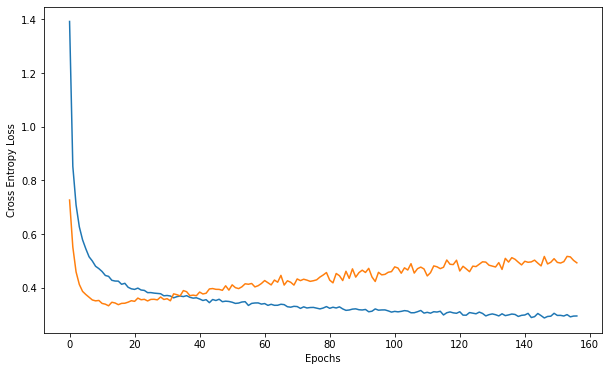

In [139]:
figure = plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(losses)), losses, label='Training loss')
plt.plot(np.arange(len(losses)), validation_losses, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")

In [140]:
torch.save(model.state_dict(), "NLPModel_Overfitting")

sigmoid = nn.Sigmoid()
testing = sigmoid(label_scores)

In [163]:
def accuracy(labels, predicted):
    total_accuracy = 0
    n = len(predicted)
    for y, p in zip(labels, predicted):
        if (y == p):
            total_accuracy +=1
    return total_accuracy/n

Model v1 = Feature vector standarized and without class weights

Model v2 = Feature vector standarized and with class weights

In [164]:
model.eval()

BiLSTM(
  (lstm1): LSTM(1041, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
  (Sigmoid): Sigmoid()
)

In [165]:
v_test = torch.from_numpy(np.array(x_test, dtype=np.float64)).view(-1, 1, 1041).float().to(device)

words_labels = model(v_test) 

In [168]:
words_labels

tensor([[0.4900, 0.4985, 0.5334,  ..., 0.5728, 0.4702, 0.5405],
        [0.5072, 0.4691, 0.5011,  ..., 0.5110, 0.5229, 0.5445],
        [0.4387, 0.5019, 0.4730,  ..., 0.4885, 0.4629, 0.5447],
        ...,
        [0.5095, 0.4933, 0.4889,  ..., 0.5466, 0.5255, 0.4523],
        [0.5278, 0.4745, 0.4873,  ..., 0.5408, 0.5146, 0.5460],
        [0.5235, 0.4721, 0.5073,  ..., 0.5313, 0.4698, 0.5294]],
       device='cuda:0', grad_fn=<SigmoidBackward>)

In [125]:
words_labels.size()

torch.Size([11350, 10])

In [169]:
y = []

for p in words_labels:
    i = 0
    m = 0
    for index, e in enumerate(p):
        if float(e) > m:
            i = index
            m = e
    y.append(i+1)

In [170]:
set(y)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [183]:
print(np.array(y))
print(y_test)

[ 8 10 10 ...  8 10  8]
[10 7 7 ... 10 7 10]


In [172]:
set(y_test)

{1, 2, 3, 4, 5, 6, 7, 9, 10}

y = []

for p in words_labels:
    i = 0
    m = 0
    for index, e in enumerate(p):
        if float(e) > m:
            i = index
            m = e
    y.append(i)

In [173]:
accuracy(y_test, y)

0.12140969162995595

In [174]:
def precision_of(labels, y, of):
    n = 0
    precision = 0
    c = 0
    for label, p in zip(labels, y):
        if (label == p) and (p == of):
            c += 1
        if (p == of):
            n+=1
            
    precision = 0 if n==0 else c / n
    return precision

In [175]:
p0 = precision_of(y_test, y, 0)
p1 = precision_of(y_test, y, 1)
p2 = precision_of(y_test, y, 2)
p3 = precision_of(y_test, y, 3)
p4 = precision_of(y_test, y, 4)
p5 = precision_of(y_test, y, 5)
p6 = precision_of(y_test, y, 6)
p7 = precision_of(y_test, y, 7)
p8 = precision_of(y_test, y, 8)
p9 = precision_of(y_test, y, 9)
p10 = precision_of(y_test, y, 10)

precision = (p0+p1+p2+p3+p4+p5+p6+p8+p9+p7+p10) / 10

In [176]:
print(precision)

0.09914015347161295


In [177]:
def recall_of(labels, y, of):
    n = 0
    recall = 0
    c = 0
    for label, p in zip(labels, y):
        if (label == p) and (p == of):
            c += 1
        if (label == of):
            n+=1
            
    recall = 0 if n==0 else c / n
    return recall

In [178]:
p0 = recall_of(y_test, y, 0)
p1 = recall_of(y_test, y, 1)
p2 = recall_of(y_test, y, 2)
p3 = recall_of(y_test, y, 3)
p4 = recall_of(y_test, y, 4)
p5 = recall_of(y_test, y, 5)
p6 = recall_of(y_test, y, 6)
p7 = recall_of(y_test, y, 7)
p8 = recall_of(y_test, y, 8)
p9 = recall_of(y_test, y, 9)
p10 = recall_of(y_test, y, 10)

recall = (p0+p1+p2+p3+p4+p5+p6+p8+p9+p7+p10) / 10

In [179]:
recall

0.05875414636642144